<a href="https://colab.research.google.com/github/SLCFLAB/hd2025_time_series/blob/main/day1/Day1_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SARIMA

많은 시계열 모델 학습에서 사용되는 “AirPassengers” 데이터를 활용해서 SARIMA 실습을 진행하겠습니다.
(The “AirPassengers” dataset in R contains the monthly totals of international airline passengers from 1949 to 1960.)

데이터의 주요 특징은 아래와 같습니다.
- Upward trend
- Strong seasonality
- Increasing variance

In [1]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# 시각화 스타일 설정
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

## 데이터 준비 및 시각화

In [2]:
from statsmodels.datasets import get_rdataset
air_data = get_rdataset('AirPassengers', 'datasets')
air_df = air_data.data

# 날짜 인덱스 생성
dates = pd.date_range('1949-01', periods=len(air_df), freq='M')
air_passengers = pd.Series(air_df['value'].values, index=dates, name='Passengers')

In [3]:
air_passengers.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 144 entries, 1949-01-31 to 1960-12-31
Freq: ME
Series name: Passengers
Non-Null Count  Dtype
--------------  -----
144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [4]:
air_passengers.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


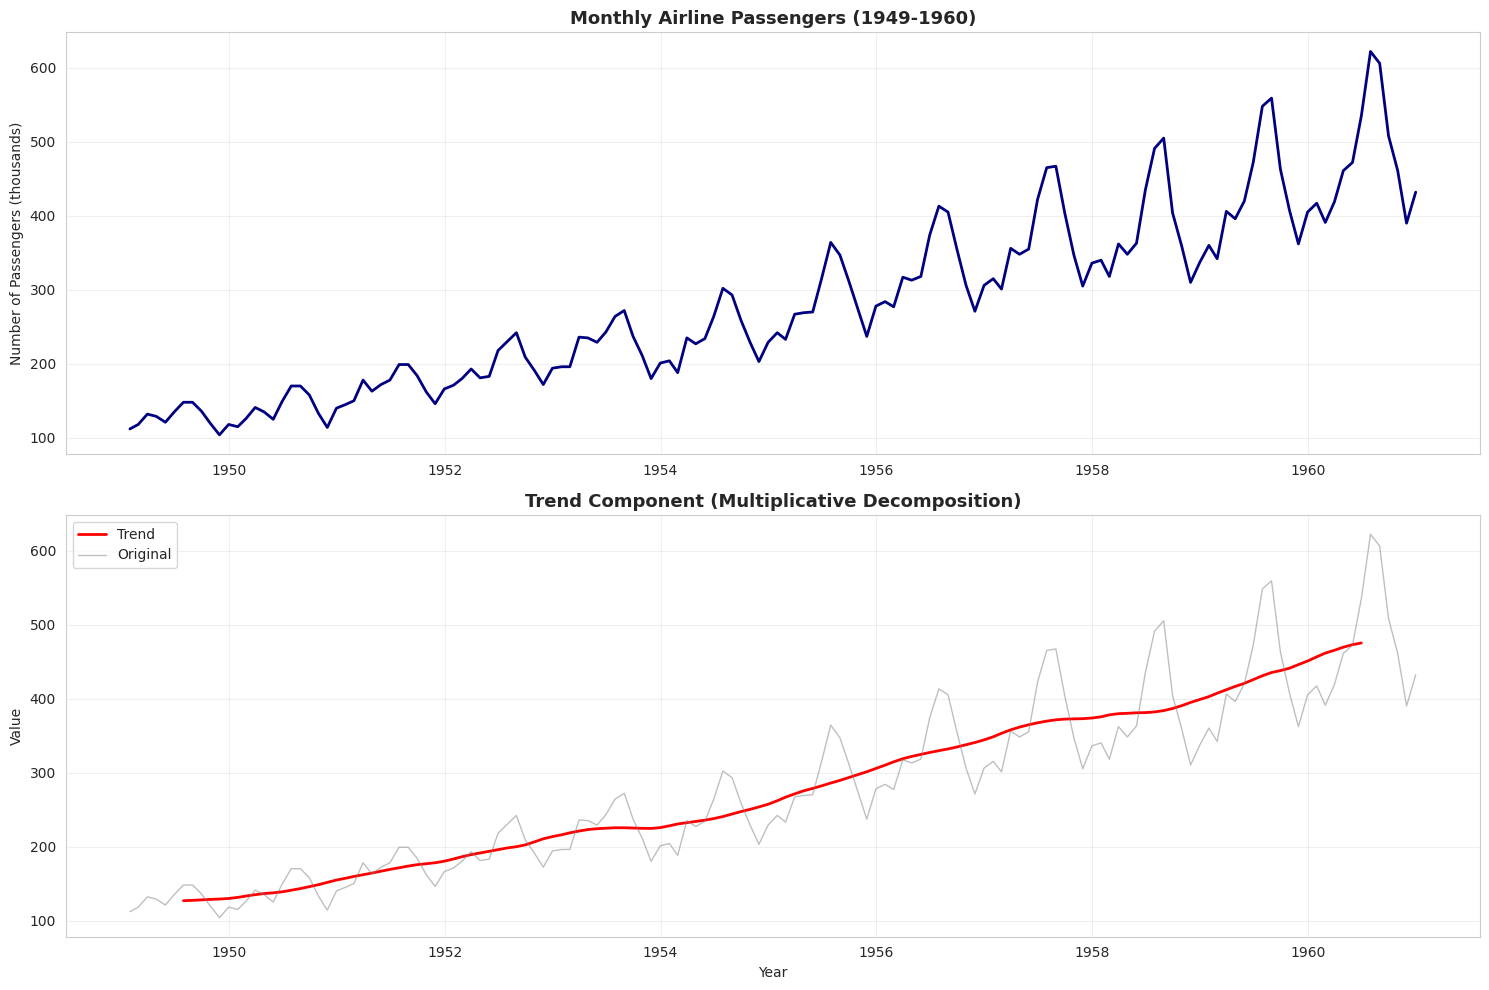

In [5]:
# 시각화
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 1-1. 원본 시계열
axes[0].plot(air_passengers.index, air_passengers.values, linewidth=2, color='navy')
axes[0].set_title('Monthly Airline Passengers (1949-1960)',
                   fontsize=13, fontweight='bold')
axes[0].set_ylabel('Number of Passengers (thousands)')
axes[0].grid(True, alpha=0.3)

# 1-2. 시계열 분해
decomposition = seasonal_decompose(air_passengers, model='multiplicative', period=12)
axes[1].plot(air_passengers.index, decomposition.trend,
             linewidth=2, label='Trend', color='red')
axes[1].plot(air_passengers.index, air_passengers.values,
             linewidth=1, label='Original', color='gray', alpha=0.5)
axes[1].set_title('Trend Component (Multiplicative Decomposition)',
                   fontsize=13, fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Model Selection

### Step 1. Stationarity Check

In [6]:
result_original = adfuller(air_passengers)
print(f"Original Series:")
print(f"  ADF Statistic: {result_original[0]:.4f}")
print(f"  p-value: {result_original[1]:.4f}")
print(f"  Stationary: {'Yes' if result_original[1] < 0.05 else 'No'}")

Original Series:
  ADF Statistic: 0.8154
  p-value: 0.9919
  Stationary: No


In [7]:
# Log 변환 (분산 안정화)
air_log = np.log(air_passengers)
result_log = adfuller(air_log)
print(f"\nLog-transformed Series:")
print(f"  ADF Statistic: {result_log[0]:.4f}")
print(f"  p-value: {result_log[1]:.4f}")
print(f"  Stationary: {'Yes' if result_log[1] < 0.05 else 'No'}")


Log-transformed Series:
  ADF Statistic: -1.7170
  p-value: 0.4224
  Stationary: No


In [8]:
# 1차 차분
air_log_diff = air_log.diff().dropna()
result_diff = adfuller(air_log_diff)
print(f"\nLog + 1st Difference:")
print(f"  ADF Statistic: {result_diff[0]:.4f}")
print(f"  p-value: {result_diff[1]:.4f}")
print(f"  Stationary: {'Yes' if result_diff[1] < 0.05 else 'No'}")


Log + 1st Difference:
  ADF Statistic: -2.7171
  p-value: 0.0711
  Stationary: No


In [9]:
# 계절 차분 추가
air_log_diff_seasonal = air_log.diff().diff(12).dropna()
result_seasonal = adfuller(air_log_diff_seasonal)
print(f"\nLog + 1st Diff + Seasonal Diff:")
print(f"  ADF Statistic: {result_seasonal[0]:.4f}")
print(f"  p-value: {result_seasonal[1]:.4f}")
print(f"  Stationary: {'Yes' if result_seasonal[1] < 0.05 else 'No'}")


Log + 1st Diff + Seasonal Diff:
  ADF Statistic: -4.4433
  p-value: 0.0002
  Stationary: Yes


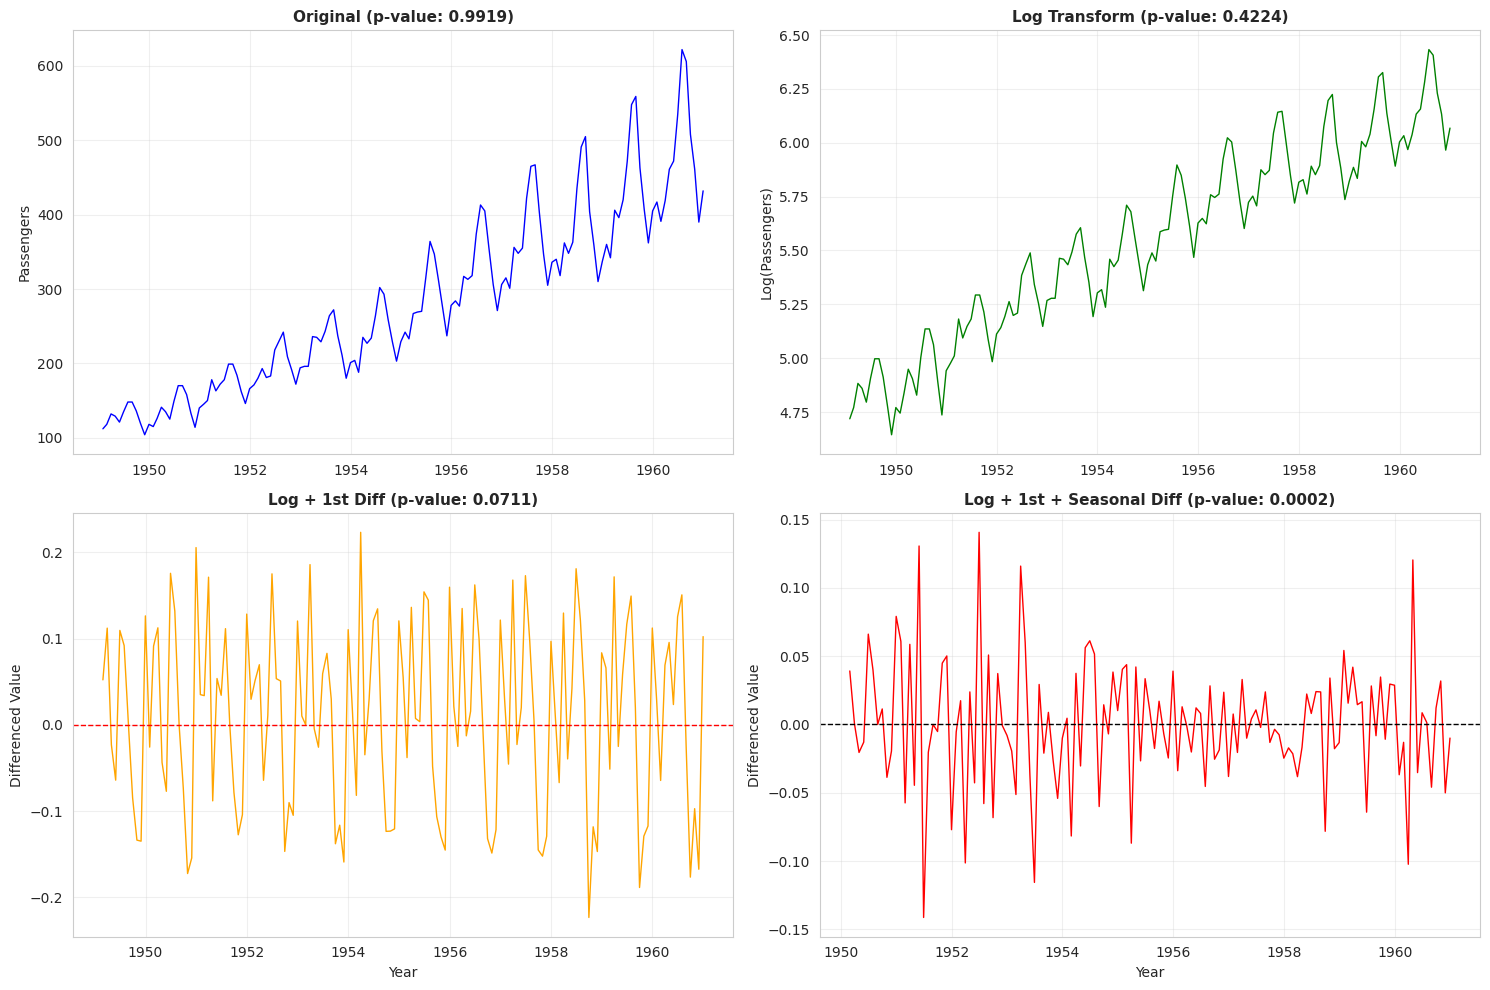

In [10]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 원본
axes[0, 0].plot(air_passengers, linewidth=1, color='blue')
axes[0, 0].set_title(f'Original (p-value: {result_original[1]:.4f})',
                      fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Passengers')
axes[0, 0].grid(True, alpha=0.3)

# Log 변환
axes[0, 1].plot(air_log, linewidth=1, color='green')
axes[0, 1].set_title(f'Log Transform (p-value: {result_log[1]:.4f})',
                      fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Log(Passengers)')
axes[0, 1].grid(True, alpha=0.3)

# Log + 1차 차분
axes[1, 0].plot(air_log_diff, linewidth=1, color='orange')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1, 0].set_title(f'Log + 1st Diff (p-value: {result_diff[1]:.4f})',
                      fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Differenced Value')
axes[1, 0].grid(True, alpha=0.3)

# Log + 1차 + 계절 차분
axes[1, 1].plot(air_log_diff_seasonal, linewidth=1, color='red')
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].set_title(f'Log + 1st + Seasonal Diff (p-value: {result_seasonal[1]:.4f})',
                      fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Differenced Value')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 2. ACF/PACF Analysis for Model Identification

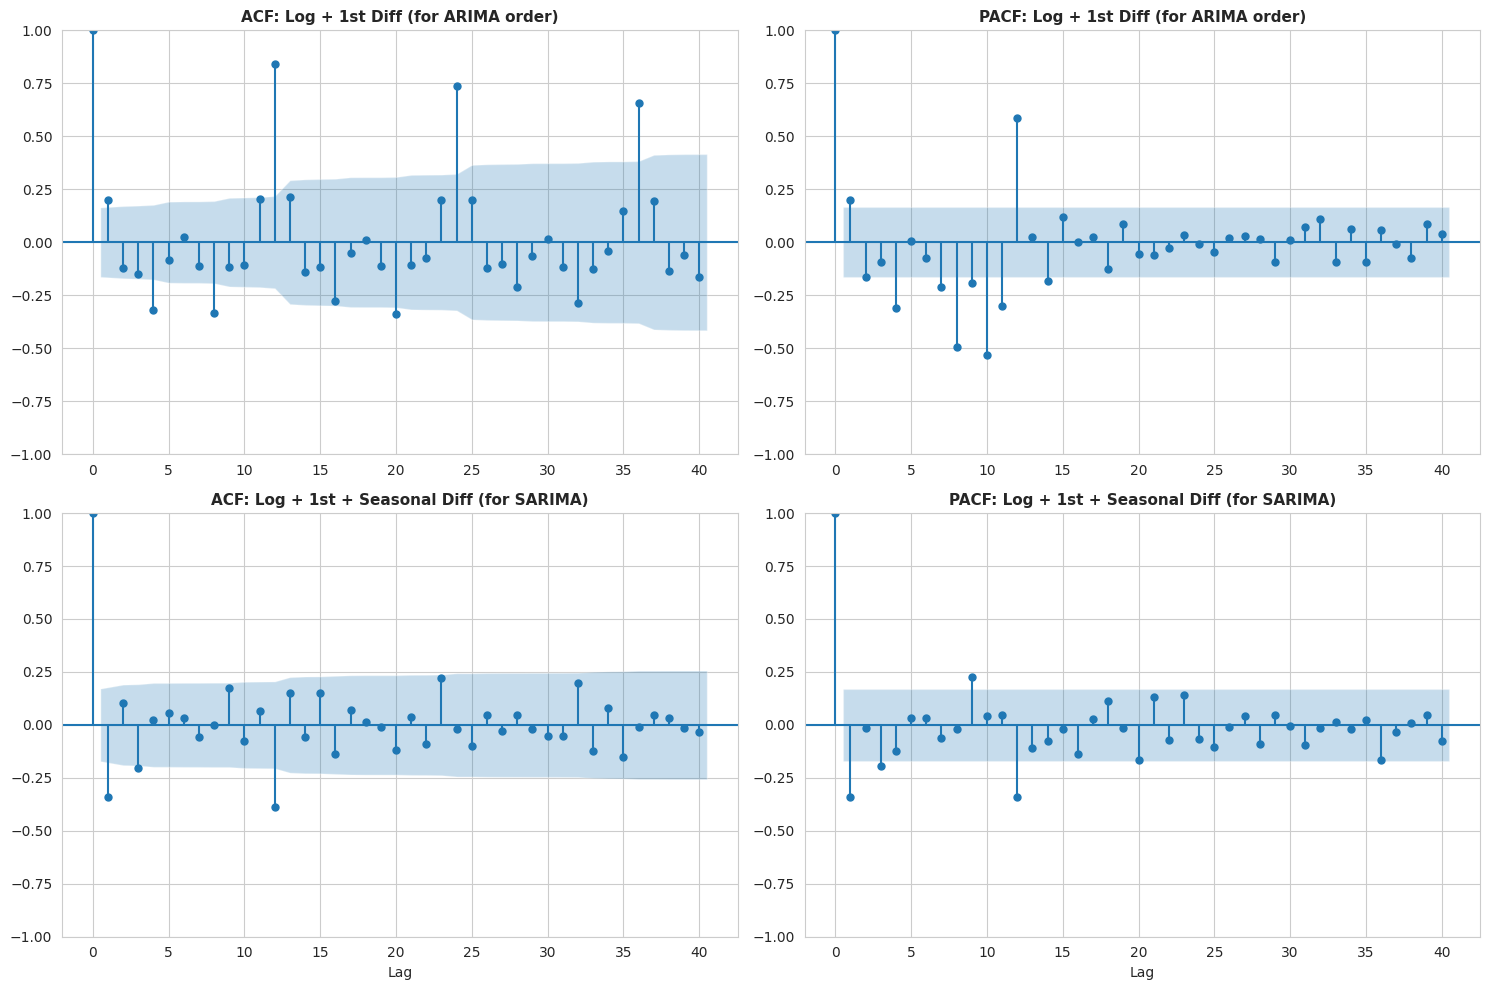

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Log + 1차 차분
plot_acf(air_log_diff, lags=40, ax=axes[0, 0], alpha=0.05)
axes[0, 0].set_title('ACF: Log + 1st Diff (for ARIMA order)',
                      fontsize=11, fontweight='bold')

plot_pacf(air_log_diff, lags=40, ax=axes[0, 1], alpha=0.05)
axes[0, 1].set_title('PACF: Log + 1st Diff (for ARIMA order)',
                      fontsize=11, fontweight='bold')

# Log + 1차 + 계절 차분
plot_acf(air_log_diff_seasonal, lags=40, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('ACF: Log + 1st + Seasonal Diff (for SARIMA)',
                      fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Lag')

plot_pacf(air_log_diff_seasonal, lags=40, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('PACF: Log + 1st + Seasonal Diff (for SARIMA)',
                      fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Lag')

plt.tight_layout()
plt.show()

ACF/PACF Interpretation:
- **12, 24, 36 시차에서 뚜렷한 스파이크**가 나타나므로 **월별 계절성 (s = 12)** 이 존재함을 의미한다.  
- **비계절 부분**에서는  
  - ACF가 **느리게 감쇠하지 않고** 초반 1‒2시차 이후 **급히 작아짐**.
  - PACF는 **1시차가 가장 두드러지고** 이후 급히 약화.
  - ⇒ 비계절부는 **MA(1)** 또는 **ARMA(1,1)** 유력. AR(1)/AR(2)도 완전히 배제되진 않지만 1순위는 아님.

- **계절 부분**에서는  
  - ACF에서 12시차 스파이크가 두드러지고 (Q=1 가능), PACF 역시 12시차에서 유의함. 따라서 **계절 AR(1)** 구조(P=1)도 가능하므로, **혼합형 (P=1, Q=1)** 도 유력한 후보가 된다.

### Step 3. Grid Search for Optimal Model

In [12]:
# Train/Test 분할 (마지막 12개월을 테스트)
train_size = len(air_log) - 12
train_data = air_log[:train_size]
test_data = air_log[train_size:]

print(f"Training size: {len(train_data)} months")
print(f"Test size: {len(test_data)} months")

# 후보 모델 정의
p_values = [0, 1, 2]
d_values = [1]  # 이미 확인됨
q_values = [0, 1, 2]
P_values = [0, 1]
D_values = [1]  # 계절 차분 필요
Q_values = [0, 1]
s_value = 12

Training size: 132 months
Test size: 12 months


In [13]:
# Grid search (may take few minutes)
print("\nSearching optimal SARIMA model...")

results = []
total_models = len(p_values) * len(d_values) * len(q_values) * len(P_values) * len(D_values) * len(Q_values)
current = 0

for p, d, q in product(p_values, d_values, q_values):
    for P, D, Q in product(P_values, D_values, Q_values):
        current += 1

        # 특정 조합 제외 (모두 0이면 안됨)
        if p == q == P == Q == 0:
            continue

        try:
            # SARIMA 모델 학습
            model = SARIMAX(train_data,
                           order=(p, d, q),
                           seasonal_order=(P, D, Q, s_value),
                           enforce_stationarity=False,
                           enforce_invertibility=False)

            fitted = model.fit(disp=False, maxiter=200)

            # 예측
            forecast = fitted.forecast(steps=len(test_data))

            # 평가 (원래 스케일로 변환)
            forecast_original = np.exp(forecast)
            test_original = np.exp(test_data)

            mse = mean_squared_error(test_original, forecast_original)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(test_original, forecast_original)
            mape = mean_absolute_percentage_error(test_original, forecast_original) * 100

            results.append({
                'order': (p, d, q),
                'seasonal_order': (P, D, Q, s_value),
                'AIC': fitted.aic,
                'BIC': fitted.bic,
                'RMSE': rmse,
                'MAE': mae,
                'MAPE': mape,
                'model': fitted
            })

            if current % 5 == 0:
                print(f"Progress: {current}/{total_models} models fitted...")

        except Exception as e:
            current_spec = f"p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}"
            print(f"Error occurred for {current_spec}: {e}")
            continue

print(f"\nTotal models successfully fitted: {len(results)}")

# 결과 정렬 및 출력
results_df = pd.DataFrame([{
    'Model': f"SARIMA{r['order']}x{r['seasonal_order']}",
    'AIC': r['AIC'],
    'BIC': r['BIC'],
    'RMSE': r['RMSE'],
    'MAE': r['MAE'],
    'MAPE': r['MAPE']
} for r in results])


Searching optimal SARIMA model...
Progress: 5/36 models fitted...
Progress: 10/36 models fitted...
Progress: 15/36 models fitted...
Progress: 20/36 models fitted...
Progress: 25/36 models fitted...
Error occurred for p=2, d=1, q=1, P=0, D=1, Q=0: Input contains infinity or a value too large for dtype('float64').
Error occurred for p=2, d=1, q=1, P=0, D=1, Q=1: Input contains infinity or a value too large for dtype('float64').
Error occurred for p=2, d=1, q=1, P=1, D=1, Q=0: Input contains infinity or a value too large for dtype('float64').
Error occurred for p=2, d=1, q=1, P=1, D=1, Q=1: Input contains infinity or a value too large for dtype('float64').
Progress: 35/36 models fitted...

Total models successfully fitted: 31


In [14]:
results_df = results_df.sort_values('AIC')

In [15]:
# Top 10 Models by AIC
results_df.head()

,Model,AIC,BIC,RMSE,MAE,MAPE
11,"SARIMA(1, 1, 0)x(0, 1, 0, 12)",-406.013687,-400.472318,39.043620,34.982968,7.414478
3,"SARIMA(0, 1, 1)x(0, 1, 0, 12)",-401.870438,-396.346090,35.947576,31.637580,6.712949
15,"SARIMA(1, 1, 1)x(0, 1, 0, 12)",-399.773042,-391.486520,40.444528,36.518151,7.737458
23,"SARIMA(2, 1, 0)x(0, 1, 0, 12)",-399.640532,-391.354010,39.190486,35.143136,7.448132
27,"SARIMA(2, 1, 2)x(0, 1, 0, 12)",-398.785377,-385.017426,22.942955,17.616723,3.848077


In [16]:
# 최적 모델 선택
best_model_info = results[results_df.index[0]]
best_model = best_model_info['model']

print(f"\n{'='*80}")
print(f"Best Model Selected:")
print(f"  SARIMA{best_model_info['order']}x{best_model_info['seasonal_order']}")
print(f"  AIC: {best_model_info['AIC']:.2f}")
print(f"  BIC: {best_model_info['BIC']:.2f}")
print(f"  RMSE: {best_model_info['RMSE']:.2f}")
print(f"  MAPE: {best_model_info['MAPE']:.2f}%")
print(f"{'='*80}")


Best Model Selected:
  SARIMA(1, 1, 0)x(0, 1, 0, 12)
  AIC: -406.01
  BIC: -400.47
  RMSE: 39.04
  MAPE: 7.41%


## Seasonal ARIMA (SARIMA) 상세 분석

**SARIMA Model Structure: SARIMA(p,d,q)(P,D,Q)s**

Non-seasonal part (p,d,q):
- p: AR order (past values)
- d: Differencing order
- q: MA order (past errors)

Seasonal part (P,D,Q)s:
- P: Seasonal AR order
- D: Seasonal differencing order
- Q: Seasonal MA order
- s: Seasonal period (12 for monthly data)

In [17]:
print(f"Selected Model: SARIMA{best_model_info['order']}x{best_model_info['seasonal_order']}")

Selected Model: SARIMA(1, 1, 0)x(0, 1, 0, 12)


In [18]:
print("Model Summary:")
print("="*60)
print(best_model.summary())

Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  132
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 205.007
Date:                            Fri, 10 Oct 2025   AIC                           -406.014
Time:                                    14:33:50   BIC                           -400.472
Sample:                                01-31-1949   HQIC                          -403.764
                                     - 12-31-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3174      0.069     -4.631      0.000      -0.452      -0.183
sigma2         0.001

**모델 구조**
- 비계절 차분(d=1), 계절 차분(D=1)
- 비계절 AR(1)만 포함, MA항과 계절 AR/MA항은 없음
- 계절 주기 s=12

## Forecasting

In [19]:
# 4-1. In-sample Fit
fitted_values = best_model.fittedvalues

# 4-2. Out-of-sample Forecast (Test set)
forecast_test = best_model.forecast(steps=len(test_data))
forecast_test_original = np.exp(forecast_test)
test_original = np.exp(test_data)

In [20]:
# 4-3. Future Forecast (24개월 ahead)
# 전체 데이터로 재학습
final_model = SARIMAX(air_log,
                      order=best_model_info['order'],
                      seasonal_order=best_model_info['seasonal_order'],
                      enforce_stationarity=False,
                      enforce_invertibility=False)
final_fitted = final_model.fit(disp=False, maxiter=200)

In [21]:
# 예측 (신뢰구간 포함)
future_steps = 24
forecast_result = final_fitted.get_forecast(steps=future_steps)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

In [22]:
# 원래 스케일로 변환
forecast_mean_original = np.exp(forecast_mean)
forecast_ci_original = np.exp(forecast_ci)

# 미래 날짜 생성
future_dates = pd.date_range(air_log.index[-1], periods=future_steps+1, freq='M')[1:]

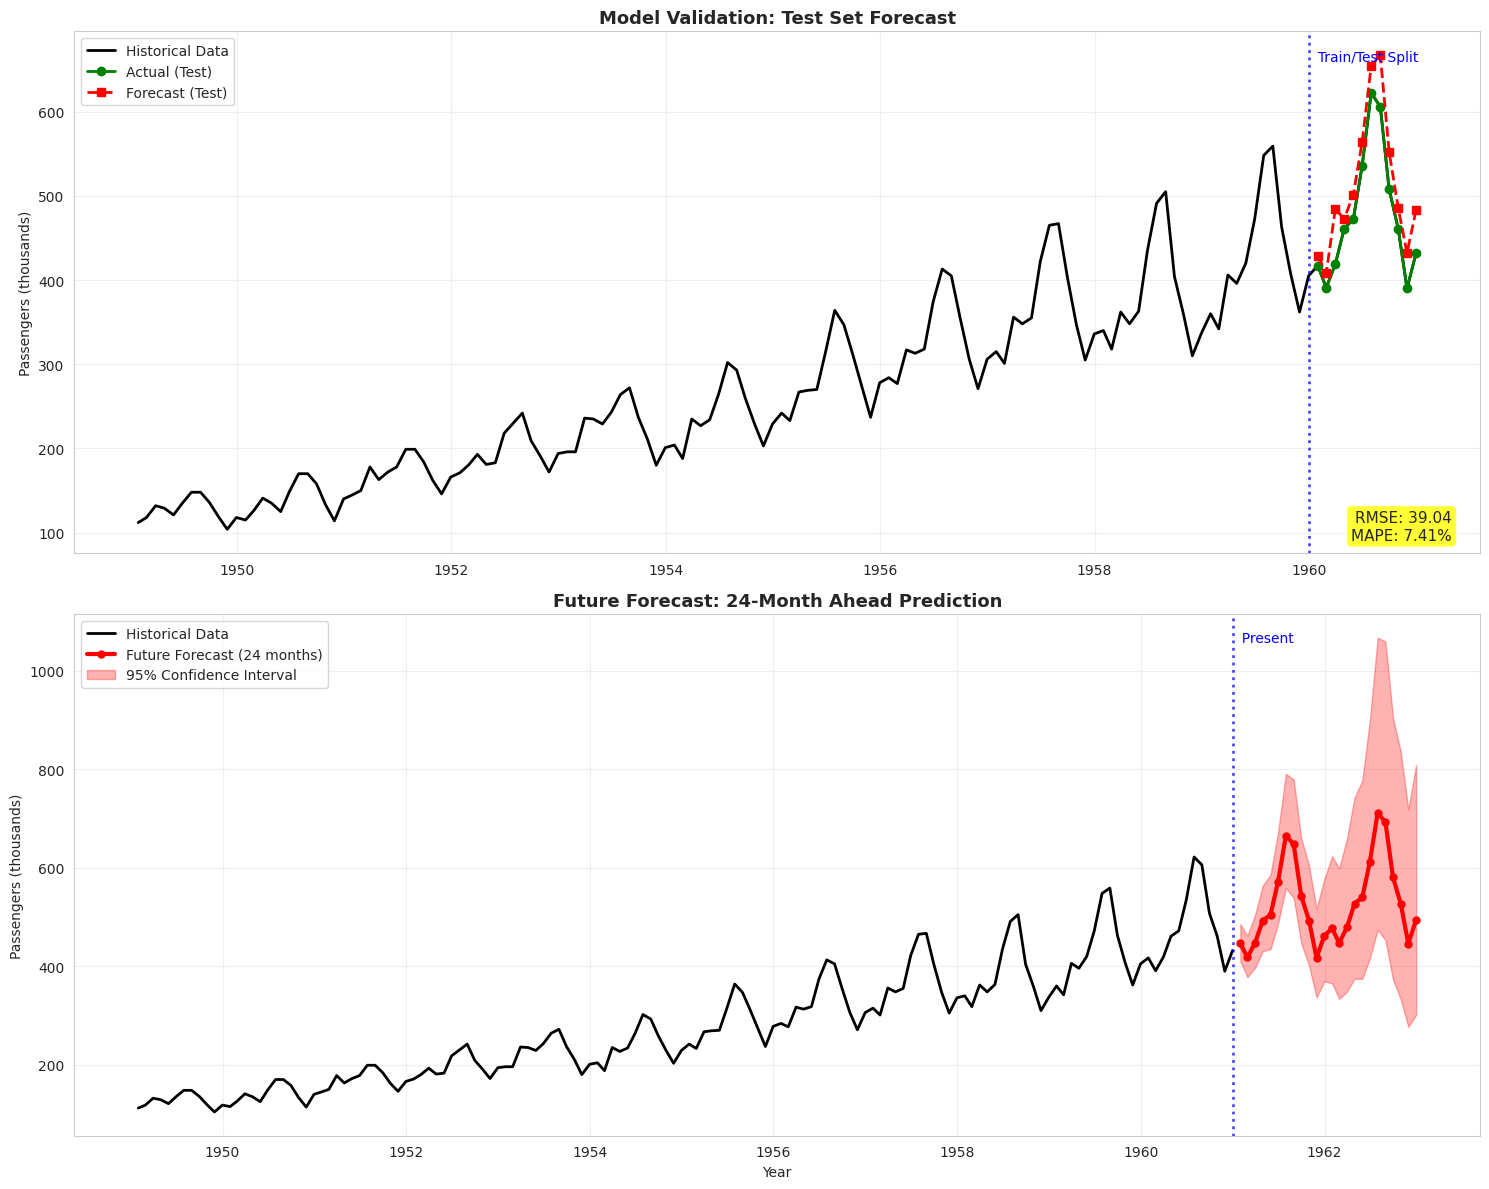

In [23]:
# 시각화
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# 4-4. Historical + Test Forecast
axes[0].plot(air_passengers.index, air_passengers.values,
             linewidth=2, label='Historical Data', color='black')
axes[0].plot(test_data.index, test_original.values,
             linewidth=2, label='Actual (Test)', color='green', marker='o')
axes[0].plot(test_data.index, forecast_test_original.values,
             linewidth=2, label='Forecast (Test)', color='red',
             linestyle='--', marker='s')

# 수직선으로 Train/Test 구분
axes[0].axvline(x=train_data.index[-1], color='blue',
                linestyle=':', linewidth=2, alpha=0.7)
axes[0].text(train_data.index[-1], axes[0].get_ylim()[1]*0.95,
             '  Train/Test Split', fontsize=10, color='blue')

axes[0].set_title('Model Validation: Test Set Forecast',
                   fontsize=13, fontweight='bold')
axes[0].set_ylabel('Passengers (thousands)')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# 성능 지표 표시
rmse = best_model_info['RMSE']
mape = best_model_info['MAPE']
axes[0].text(0.98, 0.02, f'RMSE: {rmse:.2f}\nMAPE: {mape:.2f}%',
             transform=axes[0].transAxes, fontsize=11,
             verticalalignment='bottom', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

# 4-5. Future Forecast with Confidence Interval
axes[1].plot(air_passengers.index, air_passengers.values,
             linewidth=2, label='Historical Data', color='black')
axes[1].plot(future_dates, forecast_mean_original.values,
             linewidth=3, label='Future Forecast (24 months)',
             color='red', marker='o', markersize=5)
axes[1].fill_between(future_dates,
                      forecast_ci_original.iloc[:, 0],
                      forecast_ci_original.iloc[:, 1],
                      alpha=0.3, color='red',
                      label='95% Confidence Interval')

# 수직선으로 Historical/Future 구분
axes[1].axvline(x=air_passengers.index[-1], color='blue',
                linestyle=':', linewidth=2, alpha=0.7)
axes[1].text(air_passengers.index[-1], axes[1].get_ylim()[1]*0.95,
             '  Present', fontsize=10, color='blue')

axes[1].set_title('Future Forecast: 24-Month Ahead Prediction',
                   fontsize=13, fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Passengers (thousands)')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
# 예측값 출력
print("\n" + "="*60)
print("Future Forecast (Next 24 months):")
print("="*60)
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast': forecast_mean_original.values,
    'Lower_CI': forecast_ci_original.iloc[:, 0].values,
    'Upper_CI': forecast_ci_original.iloc[:, 1].values
})
print(forecast_df.to_string(index=False))


Future Forecast (Next 24 months):
      Date   Forecast   Lower_CI    Upper_CI
1961-01-31 446.314876 410.273405  485.522499
1961-02-28 418.001865 377.909976  462.347040
1961-03-31 448.112862 397.395303  505.303247
1961-04-30 492.964502 430.651355  564.294056
1961-05-31 504.750477 434.820336  585.927159
1961-06-30 572.112835 486.661156  672.568771
1961-07-31 665.151576 559.184761  791.199348
1961-08-31 648.040380 538.838167  779.373771
1961-09-30 543.242111 447.031807  660.158822
1961-10-31 492.981416 401.692293  605.017027
1961-11-30 417.055892 336.644748  516.674086
1961-12-31 461.969592 369.553827  577.496129
1962-01-31 477.277554 365.347202  623.499680
1962-02-28 447.000352 333.725051  598.724352
1962-03-31 479.200272 348.296143  659.303599
1962-04-30 527.163452 374.255957  742.543439
1962-05-31 539.767068 374.721123  777.507513
1962-06-30 611.802627 415.919542  899.939571
1962-07-31 711.295843 474.019548 1067.343697
1962-08-31 692.997575 453.144584 1059.806640
1962-09-30 580.92902

## Forecast Accuracy Evaluation

In [25]:
test_actual = np.exp(test_data)
test_pred = forecast_test_original

# 오차 계산
errors = test_actual - test_pred
abs_errors = np.abs(errors)
pct_errors = (errors / test_actual) * 100

In [26]:
# 평가 지표
metrics = {
    'MAE (Mean Absolute Error)': mae,
    'RMSE (Root Mean Squared Error)': rmse,
    'MAPE (Mean Absolute % Error)': mape,
    'ME (Mean Error)': np.mean(errors),
    'MPE (Mean % Error)': np.mean(pct_errors),
    'Max Error': np.max(abs_errors),
    'Min Error': np.min(abs_errors)
}

print("\nForecast Accuracy Metrics:")
print("-" * 60)
for metric, value in metrics.items():
    print(f"{metric:35s}: {value:10.2f}")


Forecast Accuracy Metrics:
------------------------------------------------------------
MAE (Mean Absolute Error)          :      10.79
RMSE (Root Mean Squared Error)     :      39.04
MAPE (Mean Absolute % Error)       :       7.41
ME (Mean Error)                    :     -34.98
MPE (Mean % Error)                 :      -7.41
Max Error                          :      65.45
Min Error                          :      11.66


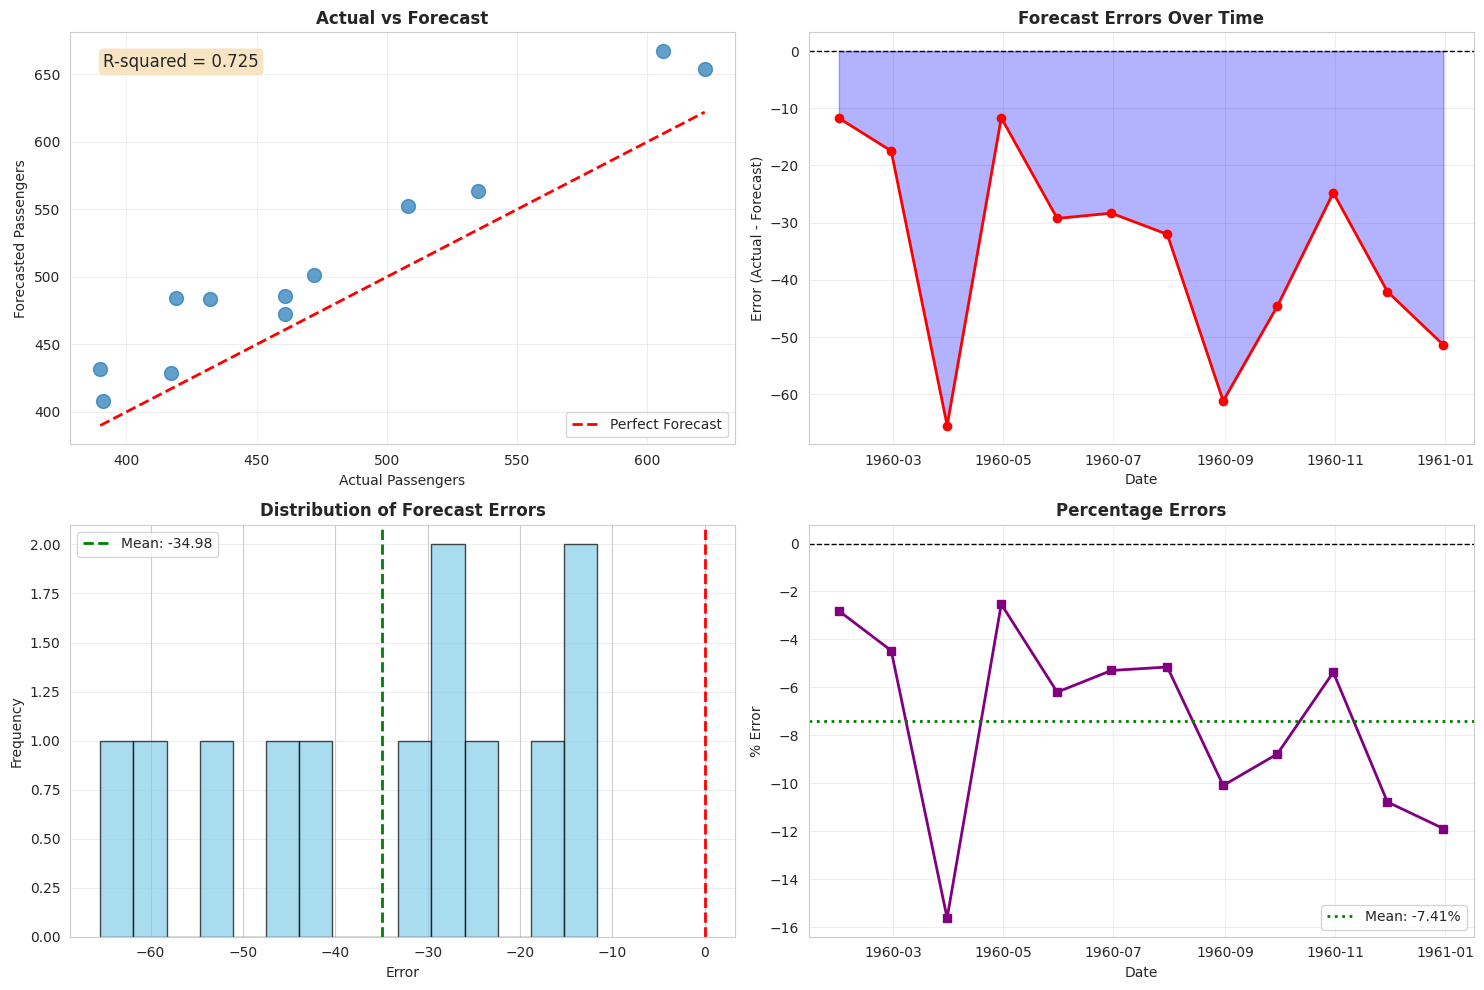

In [27]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 5-1. Actual vs Forecast
axes[0, 0].scatter(test_actual, test_pred, alpha=0.7, s=100)
axes[0, 0].plot([test_actual.min(), test_actual.max()],
                [test_actual.min(), test_actual.max()],
                'r--', linewidth=2, label='Perfect Forecast')
axes[0, 0].set_title('Actual vs Forecast', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Actual Passengers')
axes[0, 0].set_ylabel('Forecasted Passengers')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# R-squared
from sklearn.metrics import r2_score
r2 = r2_score(test_actual, test_pred)
axes[0, 0].text(0.05, 0.95, f'R-squared = {r2:.3f}',
                transform=axes[0, 0].transAxes, fontsize=12,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 5-2. Forecast Errors
axes[0, 1].plot(test_data.index, errors, linewidth=2, color='red', marker='o')
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 1].fill_between(test_data.index, 0, errors,
                         where=(errors > 0), alpha=0.3, color='red')
axes[0, 1].fill_between(test_data.index, 0, errors,
                         where=(errors < 0), alpha=0.3, color='blue')
axes[0, 1].set_title('Forecast Errors Over Time', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Error (Actual - Forecast)')
axes[0, 1].grid(True, alpha=0.3)

# 5-3. Error Distribution
axes[1, 0].hist(errors, bins=15, edgecolor='black', alpha=0.7, color='skyblue')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].axvline(x=errors.mean(), color='green', linestyle='--',
                    linewidth=2, label=f'Mean: {errors.mean():.2f}')
axes[1, 0].set_title('Distribution of Forecast Errors',
                      fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Error')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 5-4. Percentage Errors
axes[1, 1].plot(test_data.index, pct_errors, linewidth=2,
                color='purple', marker='s')
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].axhline(y=pct_errors.mean(), color='green', linestyle=':',
                    linewidth=2, label=f'Mean: {pct_errors.mean():.2f}%')
axes[1, 1].set_title('Percentage Errors', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('% Error')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## SARIMA 모델링 워크플로우

1. 데이터 탐색 및 전처리
   - 결측치 처리
   - 이상치 탐지
   - 시계열 분해 (추세, 계절성, 잔차)

2. 정상성 확보
   - 분산 안정화: Log 또는 Box-Cox 변환
   - 평균 안정화: 차분 (d, D 결정)
   - ADF 검정으로 확인

3. 모델 차수 결정
   - ACF/PACF 분석 (p, q, P, Q 결정)
   - Grid Search로 후보 모델 비교
   - AIC/BIC 기준으로 선택

4. 모델 검증
   - 잔차 진단 (white noise 확인)
   - Test set 성능 평가
   - 과적합 여부 확인

5. 예측 및 모니터링
   - 신뢰구간과 함께 예측
   - 주기적 재학습 (새 데이터 추가 시)
   - 예측 성능 지속 모니터링

Best Practices:

1. 변환 선택
   - Additive seasonality → Log transform
   - Multiplicative seasonality → No transform needed
   - Increasing variance → Box-Cox or Log

2. 차분 주의사항
   - d + D ≤ 2 권장 (과도한 차분 지양)
   - 계절 차분은 계절성이 명확할 때만
   - 차분 후 반드시 정상성 재확인

3. 모델 선택
   - 간결성 우선 (Parsimony principle)
   - AIC와 실제 예측 성능 모두 고려
   - 도메인 지식 활용

4. 예측 기간
   - 단기 예측 (1-3 주기): 높은 정확도
   - 중기 예측 (4-12 주기): 신뢰구간 확대
   - 장기 예측 (12+ 주기): 불확실성 매우 큼

5. 주의사항
   - 구조적 변화(structural break) 감지
   - 이상치의 영향 확인
   - 계절 패턴 변화 모니터링

## Model Diagnostics - Residual Analysis

In [28]:
# 잔차 추출
residuals = best_model.resid

# 잔차 통계
print("\nResidual Statistics:")
print("-" * 60)
print(f"Mean: {residuals.mean():.6f}")
print(f"Std Dev: {residuals.std():.4f}")
print(f"Min: {residuals.min():.4f}")
print(f"Max: {residuals.max():.4f}")
print(f"Skewness: {residuals.skew():.4f}")
print(f"Kurtosis: {residuals.kurtosis():.4f}")


Residual Statistics:
------------------------------------------------------------
Mean: 0.016978
Std Dev: 0.4984
Min: -3.1151
Max: 4.7185
Skewness: 4.5920
Kurtosis: 72.6972


In [29]:
# Ljung-Box 검정
lb_test = acorr_ljungbox(residuals, lags=[4, 10, 12, 20, 24, 30], return_df=True)
print("\nLjung-Box Test (White Noise Test):")
print(lb_test)


Ljung-Box Test (White Noise Test):
      lb_stat  lb_pvalue
4    0.616730   0.961187
10   0.734685   0.999959
12  32.113738   0.001329
20  32.260904   0.040596
24  32.378971   0.117870
30  32.634833   0.338607


대부분 시차까진 잔차가 완전히 백색잡음으로 보이지만 계절 시차 12에서 잔차 자기상관이 남아있다. 즉, 연간 계절성을 충분히 표현하고 있지는 못하다.

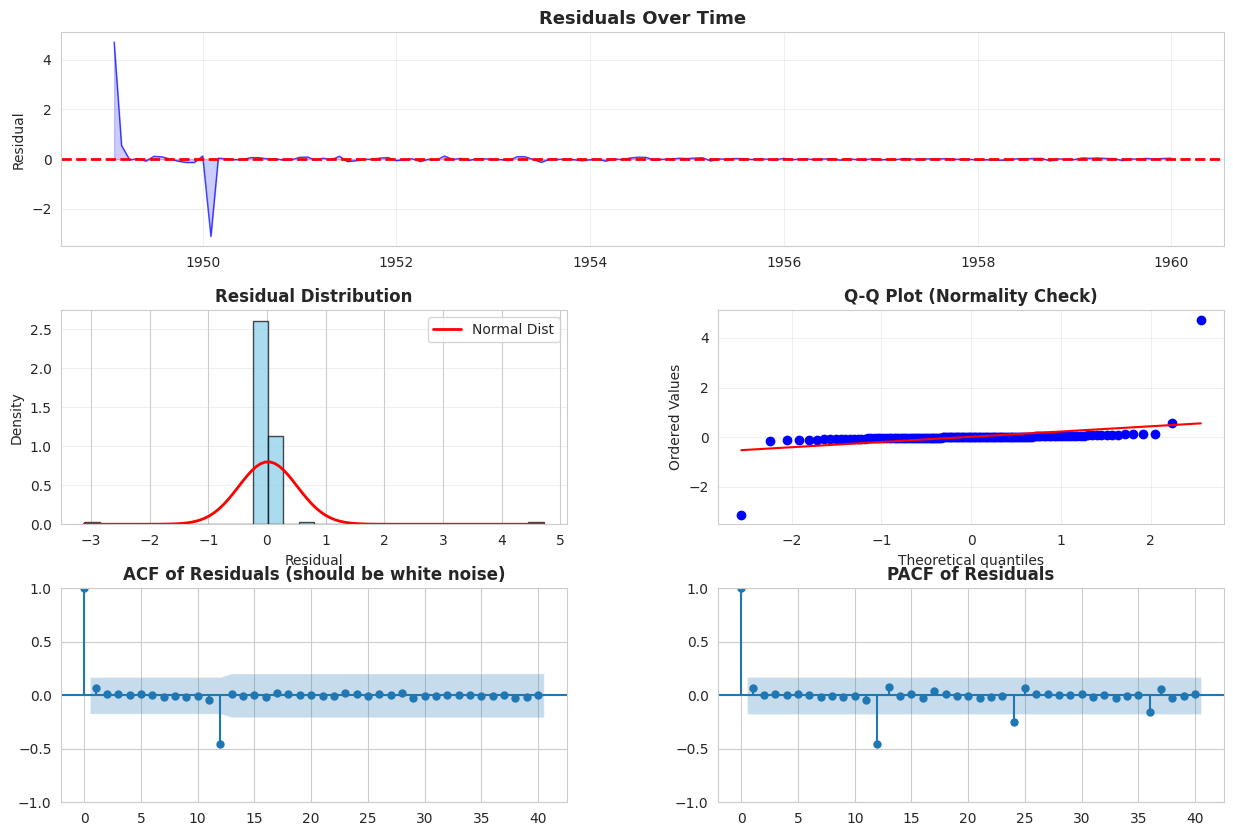

In [30]:
# 시각화
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 7-1. 잔차 시계열
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(residuals, linewidth=1, color='blue', alpha=0.7)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax1.fill_between(residuals.index, 0, residuals, alpha=0.2, color='blue')
ax1.set_title('Residuals Over Time', fontsize=13, fontweight='bold')
ax1.set_ylabel('Residual')
ax1.grid(True, alpha=0.3)

# 7-2. 잔차 히스토그램
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(residuals, bins=30, density=True, alpha=0.7,
         color='skyblue', edgecolor='black')
from scipy.stats import norm
mu, sigma = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
ax2.plot(x, norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal Dist')
ax2.set_title('Residual Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Residual')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 7-3. Q-Q Plot
from scipy import stats as sp_stats
ax3 = fig.add_subplot(gs[1, 1])
sp_stats.probplot(residuals, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 7-4. ACF of Residuals
ax4 = fig.add_subplot(gs[2, 0])
plot_acf(residuals, lags=40, ax=ax4, alpha=0.05)
ax4.set_title('ACF of Residuals (should be white noise)',
              fontsize=12, fontweight='bold')

# 7-5. PACF of Residuals
ax5 = fig.add_subplot(gs[2, 1])
plot_pacf(residuals, lags=40, ax=ax5, alpha=0.05)
ax5.set_title('PACF of Residuals', fontsize=12, fontweight='bold')

plt.show()